In [1]:
# To make sure to be in the right Python virtual environment
import sys
print(sys.executable)

/home/user/datacraft/rust_for_data_science/.venv/bin/python


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import time

## Dataset definition and visualization

In [21]:
n_blobs = 5
X, y = make_blobs(n_samples=10000, centers=n_blobs, cluster_std=0.67)#, random_state=0)

labels, counts = np.unique(y, return_counts=True)

print(X.shape)
print(X[: 10])
print(y)

(10000, 2)
[[ 6.01627437 -5.64431636]
 [-2.98352943  3.60791768]
 [-6.83121207 -5.35882427]
 [-5.01788602 -5.14018385]
 [ 6.4880084  -4.131279  ]
 [-6.02071679 -5.92790213]
 [ 4.6356052  -3.97324168]
 [ 9.57593076 -5.61675276]
 [-2.0384197   4.2270776 ]
 [-2.23591576  4.15210539]]
[3 0 4 ... 4 0 0]


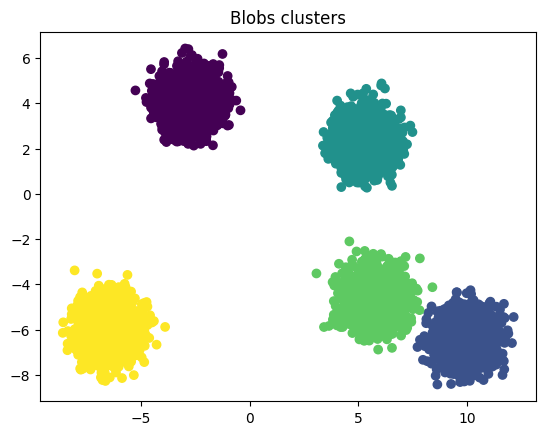

In [22]:
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title("Blobs clusters")
plt.show()

In [7]:
blobs_centroids = np.array([np.zeros(len(X[0])) for _ in range(n_blobs)])
for i in range(len(X)):
    blobs_centroids[y[i]] += X[i]
for k in range(n_blobs):
    blobs_centroids[k] /= counts[k]

print(blobs_centroids)

[[-4.27622944  8.52351804]
 [ 0.32908967  5.56204691]
 [-6.35994982  7.17450951]
 [ 8.73854835 -1.73851207]
 [ 8.26274033 -2.21063301]]


## Kmeans implementation

In [8]:
def dist(x1, x2):
    s = 0
    for i in range(len(x1)):
        s += (x1[i] - x2[i])**2
    return np.sqrt(s)

def dist_(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

def init_kmeans_pp(X, n_clusters):
    X = np.array(X)
    n_samples, _ = X.shape

    # Chooses first centroid randomly
    centroids = [X[random.randrange(n_samples)]]

    for _ in range(1, n_clusters):
        # Computes distances to the nearest centroid
        distances = np.array([min(np.sum((x - c)**2) for c in centroids) for x in X])

        # Defines proportionnal probabilities according to distances
        probabilities = distances / distances.sum()

        # Computes a new centroid
        cumulative_prob = np.cumsum(probabilities)
        r = random.random()
        for i, p in enumerate(cumulative_prob):
            if r < p:
                centroids.append(X[i])
                break

    return np.array(centroids)

In [9]:
def kmeans_alamano(X, n_clusters, max_iter=300, tol=1e-6, init=None, debug=False):
    
    # Constants of the dataset
    n_samples, n_features = X.shape

    # Initializes centroids
    if init == "kmean++":
        centroids = init_kmeans_pp(X, n_clusters)
    else:
        # Random initialization of centroids
        centroids = np.array([X[random.randrange(n_samples)] for _ in range(n_clusters)])
    prev_centroids = np.array([np.zeros(n_features) for _ in range(n_clusters)])

    # Iterations of Kmeans
    for iteration in range(max_iter):
    
        # Computes clusters according to the centroids
        clusters = [[] for _ in range(n_clusters)]
        for x_i in X:
            to_k = 0
            dist_min = np.inf
            for k in range(n_clusters):
                dist_to_k = dist(x_i, centroids[k])

                if debug :
                    print("dist_to_k < dist_min?", dist_to_k, dist_min, dist_to_k < dist_min)
                
                if dist_to_k < dist_min:
                    to_k = k
                    dist_min = dist_to_k
                
                    if debug :
                        print(dist_min)
            
            if debug :
                print(to_k)
            
            clusters[to_k].append(x_i)

        # Computes centroids
        for k in range(n_clusters):
            centroids_k = np.zeros(n_features)
            for x_ik in clusters[k]:
                centroids_k += x_ik
            centroids[k] = centroids_k/(len(clusters[k]) if len(clusters[k])>1 else 1)
            
        # Checks the convergence
        dist_centroids = 0
        for c_k, pc_k in zip(centroids, prev_centroids):
            dist_centroids += dist(c_k, pc_k)
        if dist_centroids < tol:

            if debug :
                print(iteration)
            
            break

        # Keeps previous centroids in memory
        prev_centroids = centroids.copy()
        # print(centroids)

    return centroids, clusters

## Tests

#### Python with sklearn

Python sklearn time : 0.049924033002753276
Python sklearn result : [[-6.44138173 -5.94732005]
 [ 5.34257587  2.33092484]
 [ 9.97305578 -6.4206252 ]
 [-2.72440723  4.10402502]
 [ 5.75965106 -4.631633  ]]


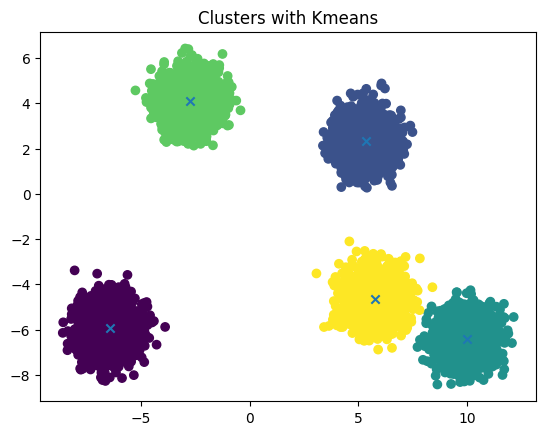

In [49]:
n_clusters = 5

# Kmeans Python from sklearn
start = time.perf_counter()
kmeans = KMeans(n_clusters=n_clusters, init="k-means++")
model = kmeans.fit(X)
clusters_py_sk = model.predict(X)
centroids_py_sk = model.cluster_centers_
print("Python sklearn time :", time.perf_counter() - start)
print("Python sklearn result :", centroids_py_sk)

# Plot clusters computed with Kmeans algorithm
plt.scatter(X[:, 0], X[:, 1], c=clusters_py_sk)
plt.scatter(centroids_py_sk[:, 0], centroids_py_sk[:, 1], marker = 'x')
plt.title("Clusters with Kmeans")
plt.show()

#### Python manual implementation

Python scratch time : 0.6673585179996735
Python scratch result : [[-6.44138173 -5.94732005]
 [ 5.34257587  2.33092484]
 [ 9.97305578 -6.4206252 ]
 [-2.72440723  4.10402502]
 [ 5.75965106 -4.631633  ]]


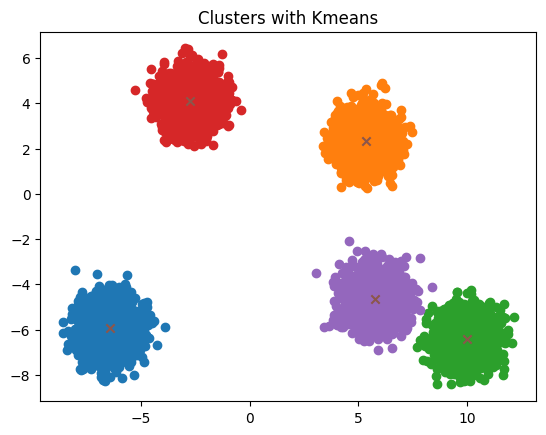

In [51]:
# Kmeans Python from scratch
start = time.perf_counter()
centroids_py_scratch, clusters_py_scratch = kmeans_alamano(X, n_clusters, init="kmeans++")
print("Python scratch time :", time.perf_counter() - start)
print("Python scratch result :", centroids_py_scratch)

# Plot clusters computed with Kmeans algorithm
for cluster in clusters_py_scratch:
    cluster = np.array(cluster)
    if len(cluster) > 0:  # Avoid empty clusters
        plt.scatter(cluster[:, 0], cluster[:, 1])
plt.scatter(centroids_py_scratch[:, 0], centroids_py_scratch[:, 1], marker = 'x')
plt.title("Clusters with Kmeans")
plt.show()

#### Rust with manual implementation

In [30]:
import ml_demos_rs

Rust scratch time : 0.005044468001869973
Rust scratch result : [[ 5.75965106 -4.631633  ]
 [-2.72440723  4.10402502]
 [-6.44138173 -5.94732005]
 [ 5.34257587  2.33092484]
 [ 9.97305578 -6.4206252 ]]


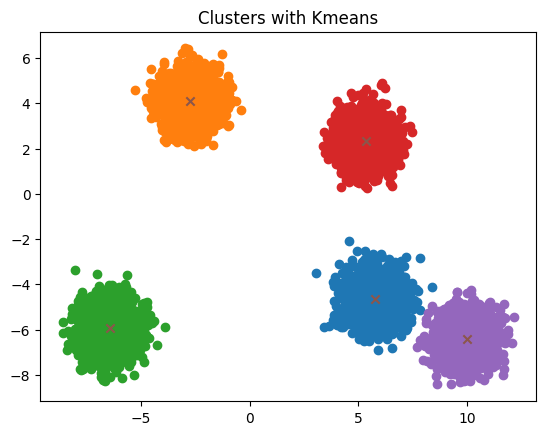

In [ ]:
# Kmeans Rust from scratch
start = time.perf_counter()
centroids_rust, clusters_rust = ml_demos_rs.kmeans_alamano(X, n_clusters, init="kmeans++")
print("Rust scratch time :", time.perf_counter() - start)
print("Rust scratch result :", centroids_rust)

# Plot clusters computed with Kmeans algorithm
for cluster in clusters_rust:
    cluster = np.array(cluster)
    if len(cluster) > 0:  # Avoid empty clusters
        plt.scatter(cluster[:, 0], cluster[:, 1])
plt.scatter(centroids_rust[:, 0], centroids_rust[:, 1], marker = 'x')
plt.title("Clusters with Kmeans")
plt.show()

### Rust with linfa_clustering

Rust scratch time : 0.16268372535705566
Rust scratch result : [[ 5.75965106 -4.631633  ]
 [-6.44138173 -5.94732005]
 [ 5.34257587  2.33092484]
 [-2.72440723  4.10402502]
 [ 9.97305578 -6.4206252 ]]


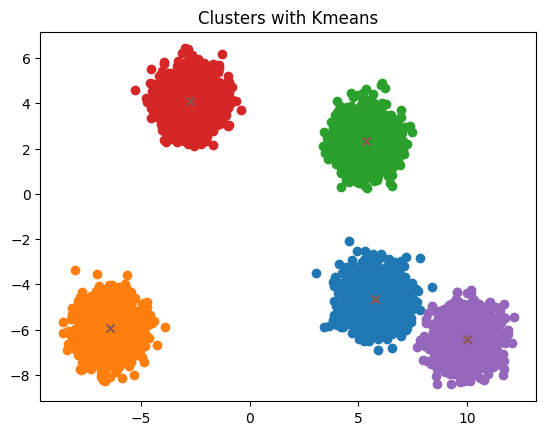

In [45]:
# Kmeans Rust from linfa_clustering
start = time.time()
centroids_rust_linfa = ml_demos_rs.linfa_kmeans_test(X, n_clusters, max_iter=300, tol=1e-6)

clusters_rust = [[] for _ in range(n_clusters)]
for x_i in X:
    to_k = 0
    dist_min = np.inf
    for k in range(n_clusters):
        dist_to_k = dist(x_i, centroids_rust[k])
        if dist_to_k < dist_min:
            to_k = k
            dist_min = dist_to_k
    clusters_rust[to_k].append(x_i)
print("Rust scratch time :", time.time() - start)
print("Rust scratch result :", centroids_rust)

# Plot clusters computed with Kmeans algorithm
for cluster in clusters_rust:
    cluster = np.array(cluster)
    if len(cluster) > 0:  # Avoid empty clusters
        plt.scatter(cluster[:, 0], cluster[:, 1])
plt.scatter(centroids_rust[:, 0], centroids_rust[:, 1], marker = 'x')
plt.title("Clusters with Kmeans")
plt.show()

## Mean time

In [66]:
N = 10

In [69]:
py_sk_time = []
py_time = []
rust_time = []

for _ in range(N):
    start = time.time()
    kmeans = KMeans(n_clusters=n_clusters, init="k-means++")
    model = kmeans.fit(X)
    clusters_py_sk = model.predict(X)
    centroids_py_sk = model.cluster_centers_
    py_sk_time.append(time.time() - start)

    start = time.time()
    centroids_py_scratch, clusters_py_scratch = kmeans_alamano(X, n_clusters, init="kmeans++")
    py_time.append(time.time() - start)

    start = time.time()
    centroids_rust, clusters_rust = ml_demos_rs.kmeans_alamano(X, n_clusters, init="kmeans++")
    rust_time.append(time.time() - start)

E_py_sk = np.mean(py_sk_time)
E_py = np.mean(py_time)
E_rust = np.mean(rust_time)

print("Mean time execution Python with sklearn :", E_py_sk)
print("Mean time execution Python with manual implementation :", E_py)
print("Mean time execution Rust with manual implementation :", E_rust)


Mean time execution Python with sklearn : 0.06166183948516846
Mean time execution Python with manual implementation : 1.3586812973022462
Mean time execution Rust with manual implementation : 0.00455632209777832
